In [25]:

import numpy as np # for mathematical functions 
import PIL # This is used for images
import PIL.Image
import tensorflow as tf # used for model building
import pathlib # Used to create paths

from tensorflow import keras # used for model building
from tensorflow.keras import layers # model layers
from tensorflow.keras.models import Sequential # import sequential model type
import kerastuner as kt  # hyper parameter tuner



## Pre processing the data set

In [26]:
data_dir = pathlib.Path("Data/flowers") # Setting directory path as a variable for the flowers data set


In [27]:
image_count =len(list(data_dir.glob("*/*.jpg"))) # Doing an image count to check the amount of images within the dataset
image_count

4124

In [28]:
list(data_dir.glob("*/*.jpg"))[0:2] # Listing some of the images, This is instance [0:2] is the first folder and first 2 images

[PosixPath('Data/flowers/daisy/5435521200_92029bbe2b_n.jpg'),
 PosixPath('Data/flowers/daisy/34518066912_0e432507bc_n.jpg')]

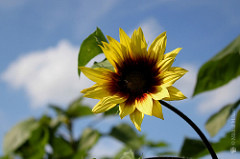

In [29]:
# checking to see if the images get displayed
sunflower = list(data_dir.glob("sunflower/*"))
PIL.Image.open(str(sunflower[0])) # checking first image in sunflower folder

### Creating and splitting the data set using keras utilities  

In [30]:
# I will have a few parameters that can change within the function these will include batch size, image width and height
# I will split the data in to a train at 80% and test 20%

def train_test_split(batch_size, img_width, img_height):

    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split = 0.2,
        subset = "training",
        seed = 123, # keeping the same training data every time
        image_size = ( img_height,img_width),
        batch_size = batch_size,)

    
    test_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        subset = "validation",
        validation_split=0.2,
        seed = 123,
        image_size = ( img_height, img_width),
        batch_size = batch_size,)

    return train_ds, test_ds


In [31]:
train_ds, test_ds = train_test_split(64,64,64) # running the function

Found 4124 files belonging to 5 classes.
Using 3300 files for training.


Found 4124 files belonging to 5 classes.
Using 824 files for validation.


In [32]:
# I need to also add class names so that the data has labels

class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


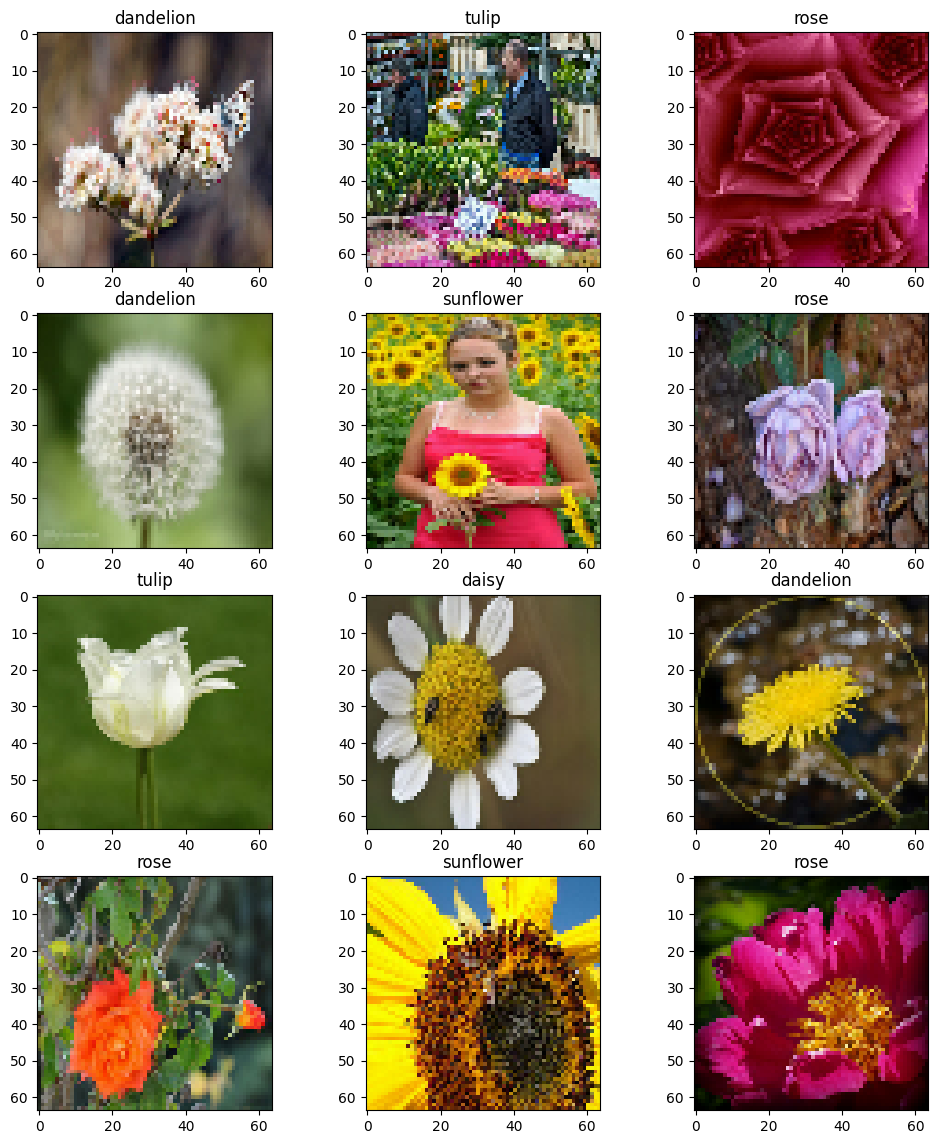

In [33]:
import matplotlib.pyplot as plt # plotting the pictures to show them

plt.figure(figsize=(12,14))
for images, labels in train_ds.take(1):
    for i in range (12):
        ax = plt.subplot(4,3, i +1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        

        plt.title(class_names[labels[i]])
        


I also did  visual check through the picture files to see if there were any files that stood out and were not so suitable to train on. I will show some examples below.

This would not always be possible on huge datasets as it takes some time to go through every picture. However as it was small I thought it was appropriate to show some examples.

Some images seemed to have no flowers in them at all so these were obvious to remove. Others may of been too many varieties of flowers in one picture for example.

I decided that this would be the best approach as when training a model you want to have clean relevant data for it to be trained on.

The picture size has been set to 64 X 64 with a batch size of 64. The reason I made the pictures this small was so that the data would be trained on quicker. Due to the fact that my computer is not the most powerful! You can see however that the pictures are fairly recognizable to the human eye even though they are pixelated. The batch size was set at 64 as this is the extent of the memory that my computer can handle.

Found 193 files belonging to 5 classes.
Using 155 files for training.


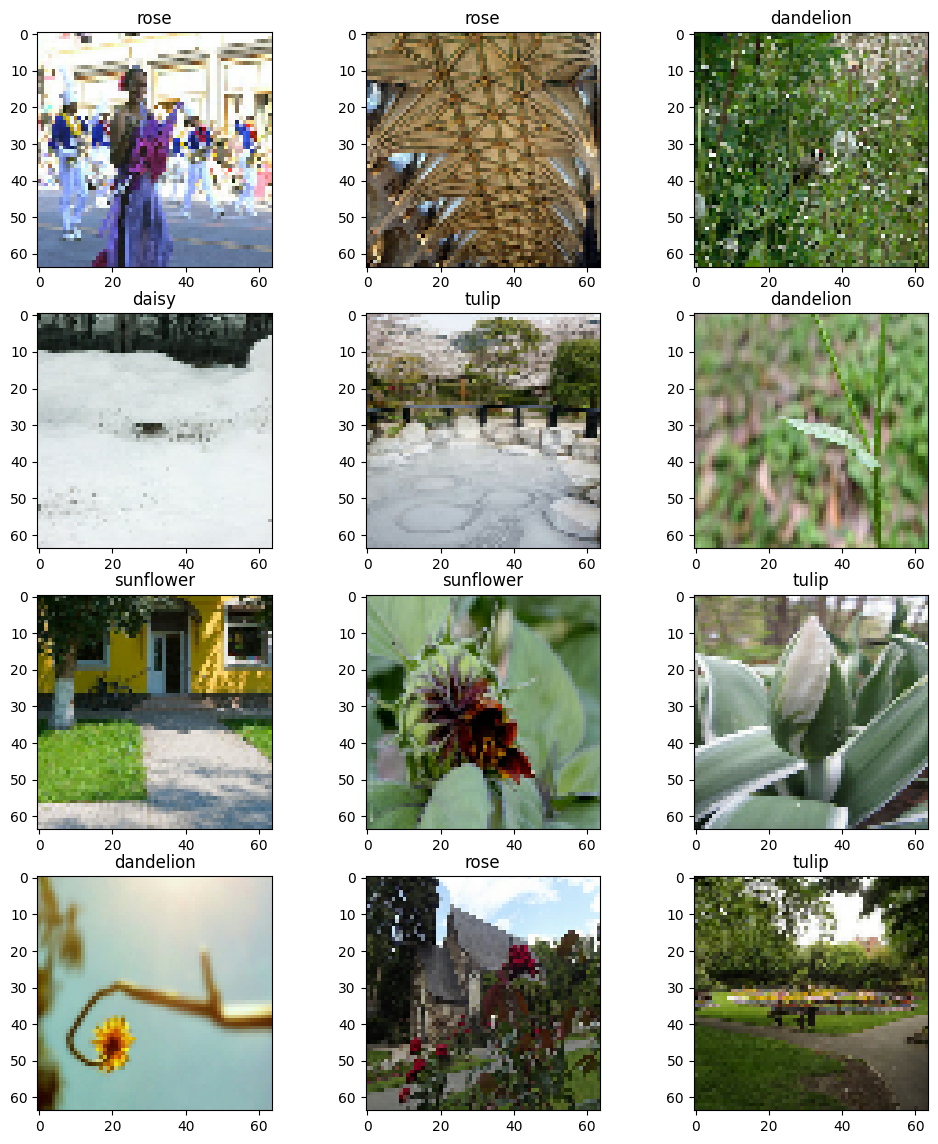

In [34]:
bad_data_dir = data_dir = pathlib.Path("Data/bad_data") # This is the directory and path for the bad data

bad_data = tf.keras.utils.image_dataset_from_directory(
            bad_data_dir,
            validation_split = 0.2,
            subset = "training",
            seed = 123,
            image_size = ( 64,64),
            batch_size = 64,)

plt.figure(figsize=(12,14))
for images, labels in bad_data.take(1):
    for i in range (12):
        ax = plt.subplot(4,3, i +1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        

        plt.title(class_names[labels[i]])



#### Showing the balance of the data set

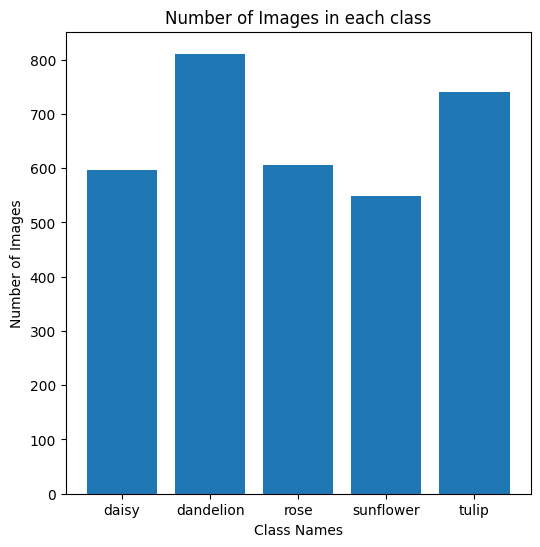

In [35]:
class_names = train_ds.class_names

label_counts = {label: 0 for label in class_names} # counting from the labels and making a dictionary to count from
for _, labels in train_ds:
    for label in labels.numpy():
        label_counts[class_names[label]] += 1


class_names = list(label_counts.keys())
class_counts = list(label_counts.values())

plt.figure(figsize=(6,6))
plt.bar(class_names, class_counts)
plt.xlabel("Class Names")
plt.ylabel("Number of Images")
plt.title("Number of Images in each class")

plt.show()


It is very clear in this diagram that the training data is bias. Dandelion has the most images and sunflower has the least. This would have an effect on the model making it more bias in predicting dandelions.

In [36]:
# This is a function to convert the keras dataset to numpy arrays. I realized this was a problem when I started using keras tuner.
def keras_ds_to_numpy_array(train_ds, test_ds): 
    
    train_images = [] # create empty lists for images and labels
    train_labels = []
    for batch in train_ds.as_numpy_iterator(): # it iterates through the data
        train_images.append(batch[0]) # appending images to a list
        train_labels.append(batch[1]) #appending labels to a list

    test_images = []
    test_labels = []
    for batch in test_ds.as_numpy_iterator():
        test_images.append(batch[0])
        test_labels.append(batch[1])

    train_images = np.concatenate(train_images) # now it joins these two lists as numpy array
    train_labels = np.concatenate(train_labels)
    test_images = np.concatenate(test_images)
    test_labels = np.concatenate(test_labels)

    print(f"Train Images shape:", {train_images.shape}) # printing the shape of the array
    print(f"Train Labels Shape:" ,{train_labels.shape}) # printing the shape of the labels array
    print(f"Number of Train Samples:", {len(train_images)}) # printing how many images
    print(f"Number of Train labels:" ,{len(train_labels)}) # printing how many labels

    print(f"Test Images shape:", {test_images.shape})
    print(f"Test Labels Shape:" ,{test_labels.shape})
    print(f"Number of Test Samples:", {len(test_images)})
    print(f"Number of Test labels:", {len(test_labels)})

    return train_images, train_labels, test_images, test_labels # returns the new variables for training and test data

In [37]:
train_images, train_labels, test_images, test_labels =  keras_ds_to_numpy_array(train_ds, test_ds)

Train Images shape: {(3300, 64, 64, 3)}
Train Labels Shape: {(3300,)}
Number of Train Samples: {3300}
Number of Train labels: {3300}
Test Images shape: {(824, 64, 64, 3)}
Test Labels Shape: {(824,)}
Number of Test Samples: {824}
Number of Test labels: {824}


## Building the model

I am going to use keras tuner to help find the best hyper parameters for my model. First I have to build a function that will have the different parameters that I will try to build the best model 

In [38]:
img_height = 64
img_width = 64

def model_builder(hp):
    
    model = tf.keras.Sequential() # Using a sequenced model
    model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3))) # rescaling the images so they are between 0 and 1 not 0 and 64

    # input layer 
    model.add(layers.Conv2D(
        filters=hp.Int("input_filters", min_value=32, max_value=256, step=32), # Values to search for best filter size
        kernel_size=3, # filter grid size
        activation="relu", # activation type
        padding="same", # padding had 0 all around the image
        input_shape=(img_height, img_width, 3)
    ))
    model.add(layers.MaxPooling2D(pool_size=(2,2))) # max pooling to reduce the image size over time but keeps valuable information

    # convolution network layers : I will use a for loop that will determine what the best amount of layers will be for the model using the keras tuner
    for i in range(hp.Int("n_conv_layers", 1,4)):
        model.add(layers.Conv2D(
            filters=hp.Int(f"conv_{i}_filters", min_value=32, max_value=256, step=32),
            kernel_size=3,
            activation="relu",
            padding="same")
        )
        model.add(layers.MaxPooling2D(pool_size=(2,2)))
    
    model.add(layers.Flatten())
    for i in range(hp.Int("n_dense_layers", 1,4)): # for loop to decide best amount of dense layers
        model.add(layers.Dense(
            units=hp.Choice(f"n_nodes_{i}", values= [10, 20, 50, 100]), #changed these to small values for better use with training time
            activation="relu")
        )
        
    model.add(layers.Dense(5)) # last layer divides up into the 5 categories
    model.add(layers.Activation("softmax")) # softmax activation used as is good for multiple category binary

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])), # different lose function to try
                  loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=["accuracy"])
    
    return model

I will now explain why I chose these parameters to search and the reason behind my model architecture:

- "Sequential" - I chose a sequential model as CNN picture analysis is a sequenced process and based on a one input tensor one output tensor system. 

#### Convolution layers

- "Rescaling" - I rescaled the images within the model. This ensures that the values of the pictures are between 0 and 1. This makes it easier for the deep learning model to make predictions as everything is between 0 and 1.

- "Convolution Layers" - The first convolution layer is the input layer. This is determined by the size of the input. Using the tuner parameter helps me determine how many filters should be applied. The following layers are then put through the tuner to see how many layers and how many filter work best for validation accuracy. The layer results could be between 1 and 4 

- "kernel  size" is then set to a 3 X 3. This means that every filter passes over the image with a 3 X 3 grid. I chose 3 X 3 as it is very common to use and as the pictures are at 64 X 64 if I had any higher it may miss vital information within the picture. I kept the kernel size the same throughout the model. 

- "Padding" is added so that there is 0's surrounding the input. This helps so that the filter doesn't miss any information on the outer pixels of the image. It is set to the same so that output size is the same size as the input size.

- "Activation" I chose Relu for the activation in all the convolution layers. I not only chose this as it is the  most common activation after the layers but because it is very effective at introducing non linearity to the network allowing it to learn complex relations in the data.It also adds sparsity in the network by not allowing any negative number and setting them to zero instead.

#### Max Pooling layers

After every convolution layer there is a max pooling layer. This is there so that it reduces the dimensions of the input layer to create a more compact representation, while still retaining the most important features. I have chosen to use make pooling at 2 X 2 which goes over the the input and takes the maximum value present in that region. It helps with the computers memory by reducing the complexity.

#### Flatten

This layer is used to flatten the input data. The input data is a multidimensional form of a picture. To be able to get our result to run through the last stage of the neural network we need to ensure it is one dimensional so that in can be processed through the last dense layers of the network.

#### Dense Layers

The dense layers are where the network starts to predict the category from the previous layers. This will determine how many layers I will have in this part. The values are how many nodes that will be used within each layer. Seeing as this is a small network I decided to keep the values low for training time reasons. 

There is a final dense layer which has 5 nodes. This is the 5 different categories that the network will predict upon. I chose the softmax as the activation as this is good activation for multiple classification.

#### Model compilation

I chose the Adam optimizer as this is a very popular choice for deep neural networks. It is very popular because it has an adaptive learning rate, which can lead to better generalization. I had a few options for learning rate to see which one would perform best. The metrics that the model will be measured on is accuracy as iw ant to see how accurate my model will be able to predict.

I chose to search three different learning rates to see which one would be most effective, learning rate is a very important part of the training in a neural network. It determines the size of the steps taken during the optimization process to update the model weights. If it is too small it may take a long time for the model to find coverage and the model may get stuck and not optimize correctly. If it is too large it can overshoot the minimum and the loss will increase rather then decrease.


### Now I have created my model structure it is time to run the keras tuner to find the best hyper parameters for my model

I chose to use the hyperband tuner function. This works by running multiple configurations of the model side by side, then it will allocate more epochs to the configurations that seem more promising. The method is called successive halving. Basically the configurations are grouped and then the best performing half is then given more iterations the next time round to see if the model parameters are effective. 

In [39]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy', # which parameter to observe
                     max_epochs=10,
                     factor=3, #the reduction factor, The smaller it is the more aggressive reduction in configurations
                     directory='tuner_results', # results saved to a directory
                     project_name='flowers')

Reloading Tuner from tuner_results/flowers/tuner0.json


In [40]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3) # early stopping used when better parameters are found to save time in tuning

In [41]:
tuner.search(train_images, train_labels, epochs=50, validation_split=0.2, callbacks=[early_stopping]) # The training search


In [42]:
# prints out best model
best_model = tuner.get_best_models(num_models=1)
print(best_model[0].summary())

# prints out best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print(best_hyperparameters.values)

#open text editor to see model layout

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 256)       2

### now i will train my model with best parameters

In [43]:
def train_and_evaluate_model(best_hyperparameters, epochs):

    checkpoint_filepath = "../best_model/checkpoint.model.keras" # filepath to save best model
    
    model = tuner.hypermodel.build(best_hyperparameters) # best model configuration

    early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss",mode="min", verbose=1, patience=3) # using early stopping to detect valuation loss
    
    # model checkpoint saves where the best model happens in the epochs. it can be recalled
    model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath, 
        monitor="val_accuracy", 
        mode="max", verbose=1, 
        save_best_only=True)
    

    # fitting the model to the training model to train
    history = model.fit(train_images,train_labels , epochs=epochs, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

    # evaluating the model with the test dataset
    test_loss, test_accuracy =model.evaluate(test_images, test_labels, verbose=0)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # plotting the validation loss and training accuracy
    plt.figure(figsize=(8,8))

    plt.subplot(1,2,1)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss ")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    print(model.summary())
    
    return keras.models.load_model(checkpoint_filepath)
    

    



I have added early stopping within my model function as well. This will stop the model from running on the amount of validation loss. If the validation loss does not improve after 3 epochs then the model will stop running. I also used the model checkpoint which will save the best model over time and will save the best model to use. This means that even if the model has gone over a few epochs it will still take the best model with the best validation accuracy.

The validation accuracy is taken from the training data then I run an evaluate model on the test data to show how the model performs with unused data.

Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 1.4705 - accuracy: 0.3330
Epoch 1: val_accuracy improved from -inf to 0.41515, saving model to ../best_model/checkpoint.model.keras
83/83 [==============================] - 59s 691ms/step - loss: 1.4705 - accuracy: 0.3330 - val_loss: 1.3617 - val_accuracy: 0.4152
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 1.2651 - accuracy: 0.4330
Epoch 2: val_accuracy improved from 0.41515 to 0.46818, saving model to ../best_model/checkpoint.model.keras
83/83 [==============================] - 55s 663ms/step - loss: 1.2651 - accuracy: 0.4330 - val_loss: 1.2403 - val_accuracy: 0.4682
Epoch 3/25
83/83 [==============================] - ETA: 0s - loss: 1.2019 - accuracy: 0.4773
Epoch 3: val_accuracy improved from 0.46818 to 0.48182, saving model to ../best_model/checkpoint.model.keras
83/83 [==============================] - 55s 666ms/step - loss: 1.2019 - accuracy: 0.4773 - val_loss: 1.2595 - val_accuracy: 0.481

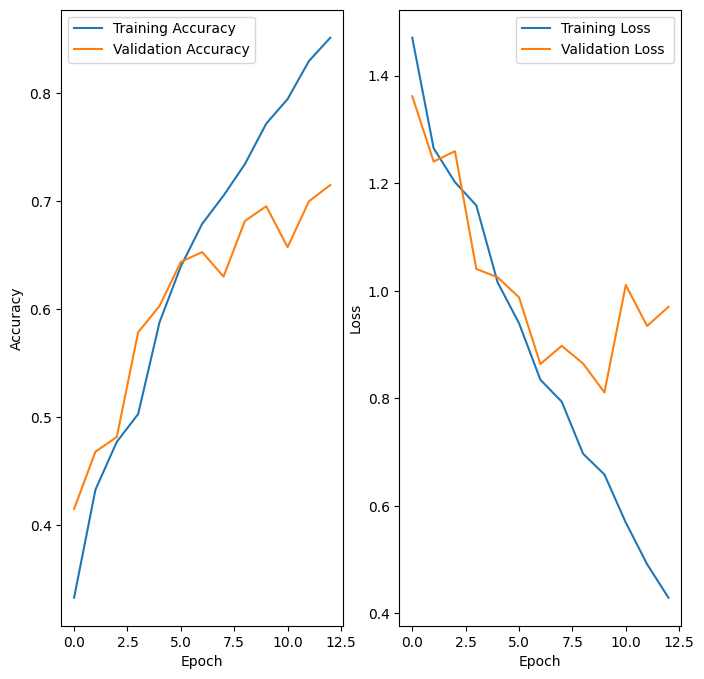

In [44]:
train_and_evaluate_model(best_hyperparameters, 25)

It is noticeable that there is some over fitting within the model. The training accuracy is consistent in the way it continues to improve while the Validation drops out around 70 % accuracy. This can occur if the data set is too small. I would like to try and improve this. This can be done by using regulation techniques. 

I will try to use Data augmentation. This adds additional training data by creating random differences of the original images. This is done by example zooming in and rotating. This will hopefully expose the model to more data and generalizations.

I will also add a dropout layer after the dense layer. This is a common method to reduce over fitting on training data. It helps by generalizing the model more by dropping out by setting a random subset of neurons to 0 during the training. 

I will now add this into my model function and see if it has any improvements. Then I will take the best model again and train that to see if the results are better.

Now I will test the new model 

In [45]:
data_augmentation = keras.Sequential(
  [ #flipping the pictures horizontal
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1), #rotating randomly
    layers.RandomZoom(0.1), # zooming randomly
  ]
)

Here I have rebuilt the model to include the data augmentation and the dropout

In [54]:
def train_and_evaluate_model(epochs, img_width, img_height):
    
    model= keras.Sequential([
        data_augmentation,
        
        layers.Rescaling(1./255, input_shape=(img_width, img_height, 3)),

        layers.Conv2D(128, (3,3), activation ="relu", padding="same"),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation ="relu", padding="same"),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(256, (3,3), activation ="relu", padding= "same"),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation ="relu", padding= "same"),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation ="relu", padding= "same"),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),

        layers.Dense(50, activation="relu"),

        layers.Dropout(0.5), # used value of 0.5 for dropout rate. I did try some other values that were higher and lowe but this seemed to yield the best results

        layers.Dense(5, name = "outputs"),

        layers.Activation("softmax")


    ])


    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate= 0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    
    early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=3)
    
    checkpoint_filepath = "../best_model/checkpoint.model.keras"

    model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath, 
        monitor="val_accuracy", 
        mode="max", verbose=1, 
        save_best_only=True
    )

    history = model.fit(train_images, train_labels, epochs=epochs, validation_split=0.2, callbacks=[early_stopping, model_checkpoint]) # fitting model to data

    test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=0) # test data results when run through the model
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    #visualizing training and validation results
    plt.figure(figsize=(8, 8))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss ")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    print(model.summary())
    
    return keras.models.load_model(checkpoint_filepath)


Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 1.5181 - accuracy: 0.3083
Epoch 1: val_accuracy improved from -inf to 0.38788, saving model to ../best_model/checkpoint.model.keras
83/83 [==============================] - 79s 919ms/step - loss: 1.5181 - accuracy: 0.3083 - val_loss: 1.3176 - val_accuracy: 0.3879
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 1.3100 - accuracy: 0.4144
Epoch 2: val_accuracy improved from 0.38788 to 0.50152, saving model to ../best_model/checkpoint.model.keras
83/83 [==============================] - 65s 788ms/step - loss: 1.3100 - accuracy: 0.4144 - val_loss: 1.1717 - val_accuracy: 0.5015
Epoch 3/25
83/83 [==============================] - ETA: 0s - loss: 1.2307 - accuracy: 0.4576
Epoch 3: val_accuracy did not improve from 0.50152
83/83 [==============================] - 59s 713ms/step - loss: 1.2307 - accuracy: 0.4576 - val_loss: 1.1357 - val_accuracy: 0.4909
Epoch 4/25
83/83 [==============================] - ETA:

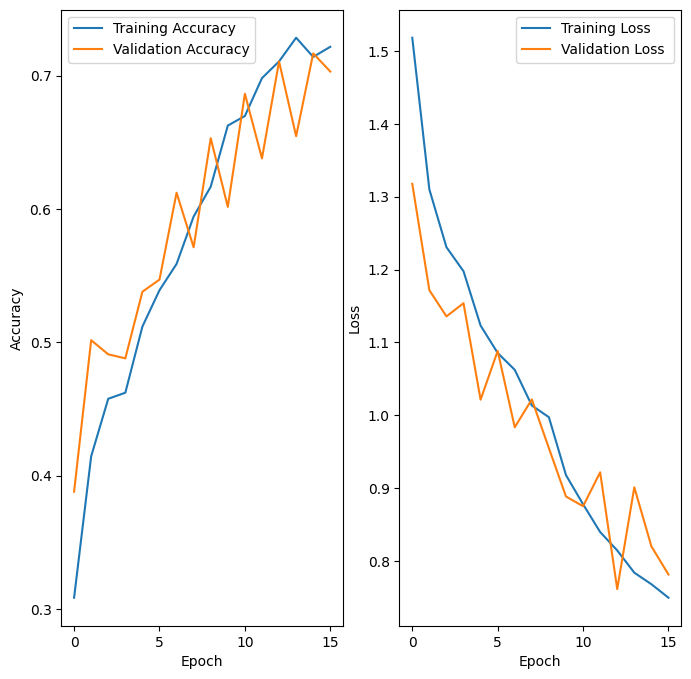

In [55]:
train_and_evaluate_model(25, 64,64)

### Conclusion

By adding the Dropout and dat augmentation you can clearly see that it has had an impact on the validation accuracy and loss within the model. I have tried a few different figures to see if they made a difference to the val lose and accuracy. The range was from 0.2 to 0.6. I could of used the keras tuner for this but decided I would try a few different values and take the best. The value ended up being 0.5, which is what I had from the beginning!

The models accuracy and loss from the test data was: Test Loss: 0.7792, Test Accuracy: 0.6881.
I thought this was a reasonable place to stop at. The validation shows that it is sticking closer to the training data, however there are spikes up and down that go through the training data curve.     . 

The model is not perfect. This can be due to a variety of factors including:

- Data quality: The size and quality of the data. If the data set was bigger the model would have more images to be trained on. Same with quality. If there were more images that contained the correct information it would improve the outcome.

- Image pixel amount: If I were to use a bigger pixel size for the image it would probably have a better effect on the accuracy. I only used 64 X 64. So the images were fairly pixelated. This would of had an effect on the quality of the image, meaning that some edges may of been missed for example. If i were to have better processing power I could have made the image more detailed. 

- Batch size: The batch size depends on how much memory you can give to train your model. After trying some different batch sizes, I realized that 64 was the biggest that I could use with my system. If I were to have a more powerful computer I would be able to have a higher batch size and therefore commit more memory to the model.

- Dense Layers: Maybe if I had more dense layers it may of made the model a bit more complex and able to predict better. 

If I were to continue with this project I would like to add to the dataset and implement more processing power so that I could run a bigger network on the data.

